# Arbitrage Modeling

## Imports

In [ ]:
# !pip install scikit-learn==0.21.3
# !pip install ta==0.4.7
# !pip install pandas==0.25.1

In [ ]:
# !pip install --upgrade scikit-learn

In [136]:
import glob
import os
import pickle
import json
import itertools
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [34]:
arb_data_paths = glob.glob('data/arb_data/*.csv')
print(len(arb_data_paths))

95


## Feature Selection

Note: closing_time feature is being removed before modeling

In [35]:
features = ['close_exchange_1','base_volume_exchange_1', 
            'nan_ohlcv_exchange_1','volume_adi_exchange_1', 'volume_obv_exchange_1',
            'volume_cmf_exchange_1', 'volume_fi_exchange_1','volume_em_exchange_1', 
            'volume_vpt_exchange_1','volume_nvi_exchange_1', 'volatility_atr_exchange_1',
            'volatility_bbhi_exchange_1','volatility_bbli_exchange_1', 
            'volatility_kchi_exchange_1', 'volatility_kcli_exchange_1',
            'volatility_dchi_exchange_1','volatility_dcli_exchange_1',
            'trend_macd_signal_exchange_1', 'trend_macd_diff_exchange_1', 
            'trend_adx_exchange_1', 'trend_adx_pos_exchange_1', 
            'trend_adx_neg_exchange_1', 'trend_vortex_ind_pos_exchange_1', 
            'trend_vortex_ind_neg_exchange_1', 'trend_vortex_diff_exchange_1', 
            'trend_trix_exchange_1', 'trend_mass_index_exchange_1', 
            'trend_cci_exchange_1', 'trend_dpo_exchange_1', 'trend_kst_sig_exchange_1',
            'trend_kst_diff_exchange_1', 'trend_aroon_up_exchange_1',
            'trend_aroon_down_exchange_1', 'trend_aroon_ind_exchange_1',
            'momentum_rsi_exchange_1', 'momentum_mfi_exchange_1',
            'momentum_tsi_exchange_1', 'momentum_uo_exchange_1',
            'momentum_stoch_signal_exchange_1', 'momentum_wr_exchange_1', 
            'momentum_ao_exchange_1', 'others_dr_exchange_1', 'close_exchange_2',
            'base_volume_exchange_2', 'nan_ohlcv_exchange_2',
            'volume_adi_exchange_2', 'volume_obv_exchange_2',
            'volume_cmf_exchange_2', 'volume_fi_exchange_2',
            'volume_em_exchange_2', 'volume_vpt_exchange_2',
            'volume_nvi_exchange_2', 'volatility_atr_exchange_2',
            'volatility_bbhi_exchange_2', 'volatility_bbli_exchange_2',
            'volatility_kchi_exchange_2', 'volatility_kcli_exchange_2',
            'volatility_dchi_exchange_2', 'volatility_dcli_exchange_2',
            'trend_macd_signal_exchange_2',
            'trend_macd_diff_exchange_2', 'trend_adx_exchange_2',
            'trend_adx_pos_exchange_2', 'trend_adx_neg_exchange_2',
            'trend_vortex_ind_pos_exchange_2',
            'trend_vortex_ind_neg_exchange_2',
            'trend_vortex_diff_exchange_2', 'trend_trix_exchange_2',
            'trend_mass_index_exchange_2', 'trend_cci_exchange_2',
            'trend_dpo_exchange_2', 'trend_kst_sig_exchange_2',
            'trend_kst_diff_exchange_2', 'trend_aroon_up_exchange_2',
            'trend_aroon_down_exchange_2',
            'trend_aroon_ind_exchange_2',
            'momentum_rsi_exchange_2', 'momentum_mfi_exchange_2',
            'momentum_tsi_exchange_2', 'momentum_uo_exchange_2',
            'momentum_stoch_signal_exchange_2',
            'momentum_wr_exchange_2', 'momentum_ao_exchange_2',
            'others_dr_exchange_2', 'year', 'month', 'day',
            'higher_closing_price', 'pct_higher', 
            'arbitrage_opportunity', 'window_length']

In [ ]:
line = '-------------'
sp = '      '

def tbl_stats_headings():
    """Prints the headings for the stats table"""
    print(sp*2, line*9, '\n', 
          sp*3, 'Accuracy Score', 
#           sp, 'True Positive Rate',
#           sp, 'False Postitive Rate', 
          sp, 'Precision',
          sp, 'Recall',
          sp, 'F1', '\n',
          sp*2, line*9, '\n', 
    )
    
def tbl_stats_row(test_accuracy, precision, recall, f1):
    """Prints the row of model stats after each param set fold"""
    print(
        sp*4, f'{test_accuracy:.4f}',     # accuracy
#         sp*3, f'{tpr:.4f}',           # roc auc
#         sp*3, f'{fpr:.4f}',      # p/r auc
        sp*2, f'{precision:.4f}',      # p/r auc
        sp*1, f'{recall:.4f}',      # p/r auc
        sp*1, f'{f1:.4f}',     # p/r auc
        sp*2, line*9
    )

def print_model_name(name, i, arb_data_paths):
    print(
    '\n\n', line*9, '\n\n', 
    f'Model {i+1}/{len(arb_data_paths)}: {name}', '\n', 
    line*9
    )

def print_model_params(i, params, pg_list):  
    print(
        sp*2, line*5, '\n', 
        sp*2, f'Model {i+1}/{len(pg_list)}', '\n',  
        sp*2, f'params={params if params else None}', '\n', 
        sp*2, line*5
    )

In [158]:
interval = 30

def get_higher_closing_price(df):
    """returns the exchange with the higher closing price"""
    
    # exchange 1 has higher closing price
    if (df['close_exchange_1'] - df['close_exchange_2']) > 0:
        return 1
    
    # exchange 2 has higher closing price
    elif (df['close_exchange_1'] - df['close_exchange_2']) < 0:
        return 2
    
    # closing prices are equivalent
    else:
        return 0
    
def get_close_shift(df, interval=interval):
    
    rows_to_shift = int(-1*(interval/5))
    
    df['close_exchange_1_shift'] = df['close_exchange_1'].shift(
        rows_to_shift - 2)
    
    df['close_exchange_2_shift'] = df['close_exchange_2'].shift(
        rows_to_shift - 2)
    
    return df

# function to create profit feature
def get_profit(df):
    """function to create profit feature"""
    
    # if exchange 1 has the higher closing price
    if df['higher_closing_price'] == 1:
        
        # return how much money you would make if you bought on exchange 2, sold
        # on exchange 1, and took account of 0.55% fees
        return (((df['close_exchange_1_shift'] / 
                 df['close_exchange_2'])-1)*100)-.55
    
    # if exchange 2 has the higher closing price
    elif df['higher_closing_price'] == 2:
        
        # return how much money you would make if you bought on exchange 1, sold
        # on exchange 2, and took account of 0.55% fees
        return (((df['close_exchange_2_shift'] / 
                 df['close_exchange_1'])-1)*100)-.55
    
    # if the closing prices are the same
    else:
        return 0 # no arbitrage

def profit(X_test, y_preds):  
    # creating dataframe from test set to calculate profitability
    test_with_preds = X_test.copy()

    # add column with higher closing price
    test_with_preds['higher_closing_price'] = test_with_preds.apply(
            get_higher_closing_price, axis=1)

    # add column with shifted closing price
    test_with_preds = get_close_shift(test_with_preds)

    # adding column with predictions
    test_with_preds['pred'] = y_preds

    # adding column with profitability of predictions
    test_with_preds['pct_profit'] = test_with_preds.apply(
            get_profit, axis=1).shift(-2)

    # filtering out rows where no arbitrage is predicted
    test_with_preds = test_with_preds[test_with_preds['pred'] != 0]

    # calculating mean profit where arbitrage predicted...
    pct_profit_mean = round(test_with_preds['pct_profit'].mean(), 2)

    # calculating median profit where arbitrage predicted...
    pct_profit_median = round(test_with_preds['pct_profit'].median(), 2)
    
    return pct_profit_mean, pct_profit_median

In [159]:
def create_models(arb_data_paths, model_type, features, param_grid):
    """
    This function takes in a list of all the arbitrage data paths, 
    does train/test split, feature selection, trains models, 
    saves the pickle file, gets performance stats for the model, 
    and returns a dataframe of performance stats and a dictionary
    of confusion matrices for each model    
    """
    
    counter = 0
    line = '---------------'
    
    base_model_name = str(model_type).split('(')[0]
    model_name_dict = {
        'LogisticRegression':'lr',
        'RandomForestClassifier':'rf'
    }
    
    # this is in case the function stops running you can pick up where you left off
    # get all model paths into a variable
    model_paths = glob.glob('models2/*.pkl')
    
    # pick target
    target = 'target'

    # iterate through the arbitrage csvs
    for i, file in enumerate(arb_data_paths):
        
        # define model name
        name = file.split('/')[2][:-8]
        
        # print status
        print_model_name(name, i, arb_data_paths)

        # read csv
        df = pd.read_csv(file, index_col=0)
        
        # convert str closing_time to datetime
        df['closing_time'] = pd.to_datetime(df['closing_time'])

        # selected features and hyperparameters
        if features and param_grid:
            pg_list = list(ParameterGrid(param_grid))
        # if theres features and no parms
        elif features and not param_grid:
            pg_list = [param_grid]
        # baseline
        else:
            features = df.drop(labels=['target', 'closing_time'], axis=1).columns.to_list()
            pg_list = [param_grid]

        
        # hyperparameter tuning
        for i, params in enumerate(pg_list):    
            # define model name
            if param_grid:
                model_name = '_'.join([name, str(max_features), str(max_depth), str(n_estimators)])
            else:
                model_name = name + '_' + model_name_dict[base_model_name]

            # define model filename to check if it exists
            model_path = f'models/{model_name}.pkl'

            # if the model does not exist
            if model_path not in model_paths:
                
                # print status
                print_model_params(i, params, pg_list)

                # remove 2 weeks from train datasets to create a  
                # two week gap between the data - prevents data leakage
                test_train_split_row = round(len(df)*.7)
                test_train_split_time = df['closing_time'][test_train_split_row]
                train_cutoff_time = test_train_split_time - dt.timedelta(days=14)

                # train and test subsets
                train = df[df['closing_time'] < train_cutoff_time]
                test = df[df['closing_time'] > test_train_split_time]

                # X, y matrix
                X_train = train[features]
                X_test = test[features]
                y_train = train[target]
                y_test = test[target]
                

                # printing shapes to track progress
                print(sp*2, 'train and test shape: ', train.shape, test.shape)
  
                # filter out datasets that are too small
                if (X_train.shape[0] > 1000) and (X_test.shape[0] > 100) and len(set(y_train)) > 1:

                    # instantiate model
                    model = model_type.set_params(**params)

                    # there was a weird error caused by two of the datasets which
                    # is why this try/except is needed to keep the function running
#                         try:

                    # fit model
                    model = model.fit(X_train, y_train)
        
                    # make predictions
                    y_preds = model.predict(X_test)
                
                    pct_profit_mean, pct_profit_median = profit(X_test, y_preds)
                    print(sp*2,'percent profit mean:', pct_profit_mean)
                    print(sp*2, 'percent profit median:', pct_profit_median, '\n\n')
                    
                    # classification report
                    print(classification_report(y_test, y_preds))
                        
                    # save model
                    pickle.dump(model, open('models/{model_name}.pkl'.format(
                                model_name=model_name), 'wb'))

#                         except:
#                             print(line*3 + '\n' + line + 'ERROR' + line + '\n' + line*3)
#                             break # break out of for loop if there is an error with modeling


                # dataset is too small
                else:
                    print(f'{sp*2}ERROR: dataset too small for {name}')

            # if the model exists
            else:
                print(f'{sp*2}{model_path} already exists.')


## Baseline

#### Logistic Regression

In [134]:
create_models(
    arb_data_paths=arb_data_paths, 
    model_type=LogisticRegression(
        solver='lbfgs', 
        multi_class='multinomial'
    ), 
    features=[], 
    param_grid={}
)


 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/95: kraken_bitfinex_bch 
 ---------------------------------------------------------------------------------------------------------------------
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             train and test shape:  (2938, 141) (2986, 141)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2986
           1       0.00      0.00      0.00         0

    accuracy                           0.99      2986
   macro avg       0.50      0.50      0.50      2986
weighted avg       1.00      0.99      1.00      2986


 --------------------------------------------------------------------------------------------------------------------- 

 Mod

#### Random Forest w/ default parameters

In [160]:
create_models(
    arb_data_paths=arb_data_paths, 
    model_type=RandomForestClassifier(
        n_jobs=-1, 
        random_state=42
    ), 
    features=[], 
    param_grid={}
)


 --------------------------------------------------------------------------------------------------------------------- 

 Model 1/95: kraken_bitfinex_bch 
 ---------------------------------------------------------------------------------------------------------------------
             ----------------------------------------------------------------- 
              Model 1/1 
              params=None 
              -----------------------------------------------------------------
             train and test shape:  (2938, 141) (2986, 141)
             percent profit mean: nan
             percent profit median: nan 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2986

    accuracy                           1.00      2986
   macro avg       1.00      1.00      1.00      2986
weighted avg       1.00      1.00      1.00      2986


 -------------------------------------------------------------------------------------------------

#### Feature Importances

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

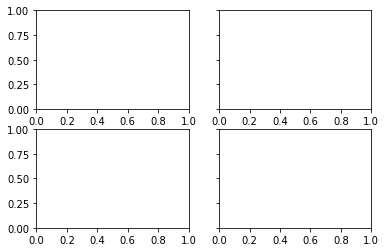

In [141]:
fig, axs = plt.subplots(2, 2, sharey=True)


pkl = glob.glob('models/*rf.pkl')

# for row in axs:
#     for col in row:
        
for p in pkl:
    with open(p, 'rb') as f:
        model = pickle.load(f)


    importances = pd.Series(model.feature_importances_, X_train.columns)
    n = 25
    plt.figure(figsize=(10,n/2))
    plt.title(f'Top {n} features')
    importances.sort_values()[-n:].plot.barh(color='blue');

## Hyperparameter Tuning

In [74]:
def preformance_metric():
    ############## Performance metrics ###############
    # TODO: put this all in a function and just return the 
    # metrics we want

    performance_list = []
    confusion_dict = {}
    
    
    # labels for confusion matrix
    unique_y_test = y_test.unique().tolist()
    unique_y_preds = list(set(y_preds))
    labels = list(set(unique_y_test + unique_y_preds))
    labels.sort()
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]

    # create confusion matrix
    confusion = pd.DataFrame(confusion_matrix(y_test, y_preds),
                             columns=columns, index=index)
    print(model_name + ' confusion matrix:')
    print(confusion, '\n')

    # append to confusion list
    confusion_dict[model_name] = confusion

    # creating dataframe from test set to calculate profitability
    test_with_preds = X_test.copy()

    # add column with higher closing price
    test_with_preds['higher_closing_price'] = test_with_preds.apply(
            get_higher_closing_price, axis=1)

    # add column with shifted closing price
    test_with_preds = get_close_shift(test_with_preds)

    # adding column with predictions
    test_with_preds['pred'] = y_preds

    # adding column with profitability of predictions
    test_with_preds['pct_profit'] = test_with_preds.apply(
            get_profit, axis=1).shift(-2)

    # filtering out rows where no arbitrage is predicted
    test_with_preds = test_with_preds[test_with_preds['pred'] != 0]

    # calculating mean profit where arbitrage predicted...
    pct_profit_mean = test_with_preds['pct_profit'].mean()

    # calculating median profit where arbitrage predicted...
    pct_profit_median = test_with_preds['pct_profit'].median()
    print('percent profit mean:', pct_profit_mean)
    print('percent profit median:', pct_profit_median, '\n\n')

    # save net performance to list
    performance_list.append([name, max_features, max_depth, n_estimators,
                             pct_profit_mean, pct_profit_median])
    ######################## END OF TODO ###########################
    
    
    

In [44]:
 
                    # precision, recall, f1 score, support
                   # precision, recall, f1, supp = precision_recall_fscore_support(y_test, y_preds, average='weighted')
                    

In [ ]:
#                     try:
#                         y_score = model.predict_proba(X_test)[:,1]
#                         print('ROC_AUC_SCORE:', roc_auc_score(y_test, y_score, average="weighted", multi_class='ovo'))
#                     except:
#                         y_score = model.predict_proba(X_test)
#                         print('ROC_AUC_SCORE:', roc_auc_score(y_test, y_score, average="weighted", multi_class='ovo'))